In [1]:
%matplotlib widget
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm as WN
from torch.optim.lr_scheduler import MultiStepLR, StepLR,ReduceLROnPlateau
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from ipywidgets import interact
types=torch.float64
torch.set_default_dtype(types)

In [31]:
class PDE_with_boundary():
    """Class for solving a PDE with Neumann and Dirichlet conditions using DGM"""
    def __init__(self, eqn_config):
        self.dim=eqn_config["dim"]
        self.total_time=eqn_config["total_time"]
        self.lambd = 4.0
        self.nu=0.05
        self.F=1.0
        self.model=ResNetLikeDGM(3,1)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.01,weight_decay=0.00001)
        self.scheduler2 = StepLR(self.optimizer,step_size=2000,gamma=0.7)
        self.scheduler=ReduceLROnPlateau(self.optimizer, 'min',factor=0.8,threshold=1e-3,patience=15)
        
    def interior_sample(self,num_sample):
        t=np.random.uniform(low=0,high=self.total_time,size=[num_sample,1])
        x=np.random.uniform(size=(num_sample,self.dim))
        return torch.tensor(np.hstack((t,x)),requires_grad=True)
    
    def dirichlet_sample(self,num_sample):
        t=np.random.uniform(low=0,high=self.total_time,size=[num_sample,1])
        x=np.stack((np.ones(num_sample),np.random.uniform(size=num_sample)*0.2),axis=1)
        return torch.tensor(np.hstack((t,x)),requires_grad=True)
    
    def neumann_sample(self,num_sample):
        Ns=int(num_sample/4)
        iz=np.stack((np.zeros(Ns),np.random.uniform(size=Ns)),axis=1)
        niz=np.repeat([[-1.0,0.0]],Ns,0)
        up=np.stack((np.random.uniform(size=Ns),np.ones(Ns)),axis=1)
        nup=np.repeat([[0.0,1.0]],Ns,0)
        down=np.stack((np.random.uniform(size=Ns),np.zeros(Ns)),axis=1)
        ndown=np.repeat([[0.0,-1.0]],Ns,0)
        der=np.stack((np.ones(Ns),0.2+np.random.uniform(size=Ns)*0.8),axis=1)
        nder=np.repeat([[1.0,0.0]],Ns,0)
        x=np.concatenate((iz,up,down,der))
        t=np.random.uniform(low=0,high=self.total_time,size=[x.shape[0],1])
        return torch.tensor(np.hstack((t,x)),requires_grad=True),torch.tensor(np.concatenate((niz,nup,ndown,nder)))
    
    def terminal_sample(self,num_sample):
        T=np.ones(shape=[num_sample,1])*self.total_time
        x=np.random.uniform(size=[num_sample,self.dim])
        return torch.tensor(np.hstack((T,x)),requires_grad=True)
        
    def loss(self,interior_sample,neumann_sample,dirichlet_sample,terminal_sample):
        
        V=self.model(interior_sample)
        dV=torch.autograd.grad(V,interior_sample, grad_outputs=torch.ones_like(V),retain_graph=True,create_graph=True,only_inputs=True)[0]
        V_t=dV[:,0]
        V_x=dV[:,1:]
        V_xx=torch.autograd.grad(dV,interior_sample,grad_outputs=torch.ones_like(dV),retain_graph=True,create_graph=True,only_inputs=True)[0][:,1:]
        diff_V=self.Lv(interior_sample, V_t,V_x,V_xx)
        L1=torch.mean(torch.square(diff_V))
        
        x_neumann,n_neumann=neumann_sample
        Vn=self.model(x_neumann)
        dVn=torch.autograd.grad(Vn,x_neumann, grad_outputs=torch.ones_like(Vn),retain_graph=True,create_graph=True,only_inputs=True)[0]
        V_nx=dVn[:,1:]
        normaldVn=torch.sum(V_nx*n_neumann,axis=1)
        L2=torch.mean(torch.square(normaldVn-self.h_n(x_neumann)))
        
        Vd=self.model(dirichlet_sample)
        L3=torch.mean(torch.square(Vd-self.h_d(dirichlet_sample)))
        
        Vter=self.model(terminal_sample)
        L4=torch.mean(torch.square(Vter-self.g_Tf(terminal_sample)))
        
        return L1+L2+3*L3+L4
    
    def h_n(self,x):
        """Neumann boundary condition"""
        return torch.zeros(x.shape[0])
    
    def h_d(self,x):
        """Dirichlet boundary condition"""
        return -0.0*torch.ones(x.shape[0])
    
    def g_Tf(self,x):
        """Terminal condition"""
        lens=x[:,1:]-torch.tensor(np.repeat([[1.0,0.05]],x.shape[0],0))
        #return torch.zeros(x.shape[0])
        return torch.sqrt(torch.sum(lens*lens,axis=1))
        
    def Lv(self, x, V_t,V_x,V_xx):
        #return V_t-0.5*torch.sum(V_xx,axis=1)
        return V_t+self.nu*torch.sum(V_xx,axis=1)-self.lambd*torch.sum(V_x*V_x,axis=1)+self.F
    
    def train(self,Nsteps):
        start_time = time.time()
        training_history = []
        interior_valid = self.interior_sample(512)
        neumann_valid= self.neumann_sample(512)
        dirichlet_valid=self.dirichlet_sample(512)
        terminal_valid=self.terminal_sample(512)

        # begin sgd iteration
        for step in range(Nsteps+1):
            #print(step)
            interior = self.interior_sample(512)
            neumann= self.neumann_sample(512)
            dirichlet=self.dirichlet_sample(512)
            terminal=self.terminal_sample(512)
            loss=self.loss(interior,neumann,dirichlet,terminal)
            self.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            for _ in range(10):
                
                self.optimizer.step()
                #self.scheduler.step(loss)
                self.scheduler2.step()
            
            
            if step % 200==0:
                
                loss = self.loss(interior_valid,neumann_valid,dirichlet_valid,terminal_valid).detach().numpy()
                #y_init = self.y_0.detach().numpy()[0]
                elapsed_time = time.time() - start_time
                training_history.append([step, loss, elapsed_time])
                print("Epoch ",step," time ", elapsed_time," loss ", loss)

        return np.array(training_history)
    def control(self,t,X):
        pos=torch.tensor(np.hstack((t,X)),requires_grad=True)
        u=self.model(pos)
        alpha=-np.sqrt(self.lambd)*torch.autograd.grad(u,pos)[0]
        return alpha.detach().numpy()
    def save_model(self,file_name):
        torch.save(self.model.state_dict(), file_name)
    def load_model(self,file_name):
        self.model.load_state_dict(torch.load(file_name))

In [32]:

sigma = torch.tanh

class DGMCell(nn.Module):
    def __init__(self, d, M, growing, weight_norm):
        super().__init__()
        wn = WN if weight_norm else lambda x: x

        self.Uz = wn(nn.Linear(d, M, bias=False))
        self.Ug = wn(nn.Linear(d, M, bias=False))
        self.Ur = wn(nn.Linear(d, M, bias=False))
        self.Uh = wn(nn.Linear(d, M, bias=False))

        self.Wz = wn(nn.Linear(M, M))
        self.Wg = wn(nn.Linear(M, M))
        self.Wr = wn(nn.Linear(M, M))
        self.Wh = wn(nn.Linear(M, M))

        self.A = (lambda x: x) if growing else sigma

    def forward(self, SX):
        S, X = SX
        Z = sigma(self.Uz(X) + self.Wz(S))
        G = sigma(self.Ug(X) + self.Wg(S))
        R = sigma(self.Ur(X) + self.Wr(S))
        H = self.A(self.Uh(X) + self.Wh(S*R))
        S = (1-G)*H + Z*S

        return S, X


def _set_convert(flag):
    if flag: return lambda X: X[0]
    return lambda X: torch.stack(X, -1)


class ResNetLikeDGM(nn.Module):
    """
    DGM algorithm from https://arxiv.org/pdf/1708.07469.pdf
    Args:
    -----
    d_in and d_out- input and ouput dimensions of the problem
    M - layers' width
    L - recurrency depth
    """
    def __init__(
            self, d_in, d_out, M=50, L=3,
            growing=False, as_array=True, weight_norm=False):
        super().__init__()
        wn = WN if weight_norm else lambda x: x
        self.W0 = wn(nn.Linear(d_in, M))
        self.W1 = wn(nn.Linear(M, d_out))
        self._convert = _set_convert(as_array)

        self.layers = []
        for l in range(L):
            self.layers.append(DGMCell(d_in, M, growing, weight_norm))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, *X):
        X = self._convert(X)
        S = sigma(self.W0(X))
        S,_ = self.layers((S, X))
        return self.W1(S).squeeze_(-1)


In [33]:
pde=PDE_with_boundary({"dim":2,"total_time":1.0,"Ndis":20})

In [ ]:
#pde.save_model('calor.pth')

In [34]:
pde.train(8000)
#pde.load_model('calor.pth')

Epoch  0  time  0.1318526268005371  loss  22222.937112822878
Epoch  200  time  12.194213628768921  loss  0.260618213690902
Epoch  400  time  24.261128664016724  loss  0.18460660231787301
Epoch  600  time  36.317837715148926  loss  0.1616035904949072
Epoch  800  time  48.323464155197144  loss  0.15093743181946395
Epoch  1000  time  60.37037515640259  loss  0.1430659025855784
Epoch  1200  time  72.39722037315369  loss  0.13791290738084858
Epoch  1400  time  84.4243757724762  loss  0.13522189262437473
Epoch  1600  time  96.81481623649597  loss  0.1335565479270278
Epoch  1800  time  109.67430067062378  loss  0.13263483781830354
Epoch  2000  time  122.73514604568481  loss  0.1322699633453987


array([[0.00000000e+00, 2.22229371e+04, 1.31852627e-01],
       [2.00000000e+02, 2.60618214e-01, 1.21942136e+01],
       [4.00000000e+02, 1.84606602e-01, 2.42611287e+01],
       [6.00000000e+02, 1.61603590e-01, 3.63178377e+01],
       [8.00000000e+02, 1.50937432e-01, 4.83234642e+01],
       [1.00000000e+03, 1.43065903e-01, 6.03703752e+01],
       [1.20000000e+03, 1.37912907e-01, 7.23972204e+01],
       [1.40000000e+03, 1.35221893e-01, 8.44243758e+01],
       [1.60000000e+03, 1.33556548e-01, 9.68148162e+01],
       [1.80000000e+03, 1.32634838e-01, 1.09674301e+02],
       [2.00000000e+03, 1.32269963e-01, 1.22735146e+02]])

In [37]:
def proyectar_adentro(X):
    x=X[0]
    y=X[1]
    if x<0.0:
        x=0.0
    elif x>1.0:
        x=1.0
    if y<0:
        y=0.0
    elif y>1.0:
        y=1.0
    return [x,y]

def control_posible(t,X):
    n=np.array([1.0-X[0],0.1-X[1]])
    return n/np.linalg.norm(n)
def simular_trayectoria(control,dt,Tf,X0,lam,nu,proyectar):
    N=int(Tf/dt)
    Xis=np.random.normal(loc=0,scale=np.sqrt(dt),size=(N,2))
    X=np.zeros((N,2))
    X[0]=X0
    t=0
    for i in range(1,Xis.shape[0]):
        n=control(t,X[i-1])
        X[i][0]=X[i-1][0]+2*np.sqrt(lam)*(n[0])*dt+np.sqrt(2*nu)*Xis[i][0]
        X[i][1]=X[i-1][1]+2*np.sqrt(lam)*(n[1])*dt+np.sqrt(2*nu)*Xis[i][1]
        if proyectar:
            X[i]=proyectar_adentro(X[i])
        t+=dt
    return X

        

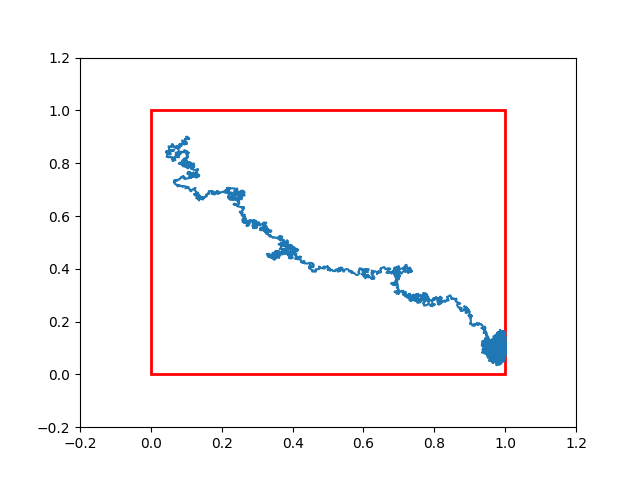

In [81]:
dt=0.0001
Tf=1.0
X0=[0.1,0.9]
lam=pde.lambd
nu=pde.nu
X=simular_trayectoria(control_posible,dt,Tf,X0,lam,nu,True)
plt.figure()
plt.cla()
plt.plot(X[:,0],X[:,1])
rect = patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.xlim((-0.2,1.2))
plt.ylim((-0.2,1.2))
plt.show()
plt.grid()

interactive(children=(FloatSlider(value=1.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.draw(t)>

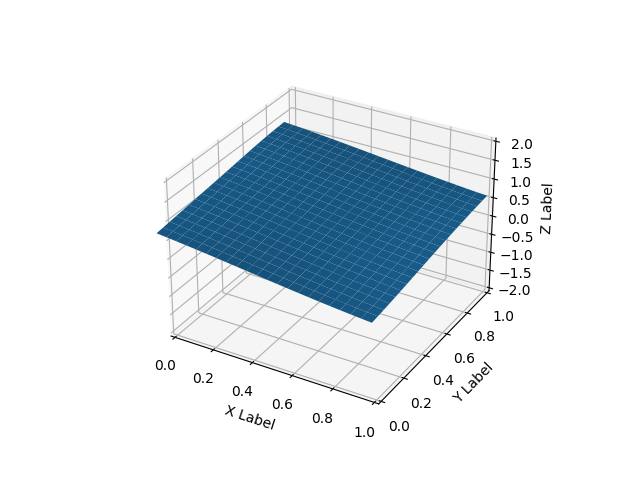

In [36]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-0.05, 1.05, 0.05)
X, Y = np.meshgrid(x, y)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(-5,5)

def draw(t):  
    ax.cla()
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_zlim(-2,2)
    times=t*np.ones(np.ravel(X).shape[0])
    tes=torch.tensor(np.stack((times,np.ravel(X), np.ravel(Y)),axis=1))
    zs =pde.model(tes).detach().numpy()
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z)

interact(draw,t=widgets.FloatSlider(min=0, max=1.0, step=0.01, value=10))
